In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import seaborn as sns
from matplotlib import pyplot
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import math

#parameters for selecting data: type in the start date, the latest available date in the data is the end date
param_start_date='11/08/2016'
#if param_period is set as after, then selecting the time period after the param_start_date
#if param_period is set as before, then selecting the time period before the param_start_date for equal number of tweets as after the date
#if param_period is empty then selecting all the data
param_period=''

In [2]:
#read tweets and stock market data
name_tweets = "tweet_stock_results.json"

with open(name_tweets, "r") as file:
    tweets_dfxx = pd.read_json(file, orient='index')
print(tweets_dfxx.columns)

tweets_dfxx.sort_index(inplace=True)
tweets_dfxx = tweets_dfxx.reset_index(drop=True)

#keep only the tweet data and drop empty rows
tweets_dataframe=tweets_dfxx[tweets_dfxx["orig changes"].notnull()]

print("Number of tweets: ", len(tweets_dataframe))

if param_period=='':
    tweets_df=tweets_dataframe
else:

    #select the data sets based on the param_start_date
    tweets_dfa=tweets_dataframe.loc[tweets_dataframe["timestamp"] > datetime.strptime(param_start_date, '%m/%d/%Y')]
    print("Number of tweets after the start date: ", len(tweets_dfa))

    before=len(tweets_dataframe)-2*len(tweets_dfa)
    tweets_dfb=tweets_dataframe.loc[tweets_dataframe.index>before]
    tweets_dfb=tweets_dfb.loc[tweets_dfb["timestamp"] <= datetime.strptime(param_start_date, '%m/%d/%Y')]
    print("Number of tweets before the start date: ", len(tweets_dfb))

    if param_period=='after':
        tweets_df=tweets_dfa
    if param_period=='before':
        tweets_df=tweets_dfb    

Index(['daily change', 'date', 'difference', 'orig changes', 'orig stock',
       'predicted changes', 'prev stock', 'text', 'timestamp', 'tweet'],
      dtype='object')
Number of tweets:  1685


In [3]:
#partition of the data in six classes
tweets_dfbp=tweets_df.loc[tweets_df["orig changes"]=='BIGPOS']
print(len(tweets_dfbp))
tweets_dfbn=tweets_df.loc[tweets_df["orig changes"]=='BIGNEG']
print(len(tweets_dfbn))
tweets_dfmp=tweets_df.loc[tweets_df["orig changes"]=='MEDPOS']
print(len(tweets_dfmp))
tweets_dfmn=tweets_df.loc[tweets_df["orig changes"]=='MEDNEG']
print(len(tweets_dfmn))
tweets_dfsp=tweets_df.loc[tweets_df["orig changes"]=='SMAPOS']
print(len(tweets_dfsp))
tweets_dfsn=tweets_df.loc[tweets_df["orig changes"]=='SMANEG']
print(len(tweets_dfsn))

294
207
422
395
159
208


In [4]:
def most_common(data,number):
    most_common = Counter(" ".join(data["text"].dropna()).split()).most_common(number)
    print("Most common words: ", most_common)


def aggregate_tfidf(data,number):
    # Ignore too common terms (max_df = .25)
    v_data = TfidfVectorizer(max_df = .25)
    X_data = v_data.fit_transform(data["text"])

    X_mean= X_data.mean(axis=0)
    vec =[]
    for i in range(len(data)):
        vec.append(X_mean.item(i))

    data['tf_idf']=pd.Series(vec, index=data.index)
    #print(data.head())
    
    highest = [v_data.get_feature_names()[id] for id in (-X_data.mean(axis=0).A).argsort()[0][:number]]
    #print("Highest scores: ", highest)



In [5]:
#print most common x words
#most_common(tweets_dfbp,20)

#aggregate TF/IDF for sentence vector and print most common x words
aggregate_tfidf(tweets_dfbp,20)
aggregate_tfidf(tweets_dfbn,20)
aggregate_tfidf(tweets_dfmp,20)
aggregate_tfidf(tweets_dfmn,20)
aggregate_tfidf(tweets_dfsp,20)
aggregate_tfidf(tweets_dfsn,20)


C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
tweets_dfb=tweets_dfbp.append(tweets_dfbn)
print(len(tweets_dfb))
tweets_dfm=tweets_dfmp.append(tweets_dfmn)
print(len(tweets_dfm))
tweets_dfs=tweets_dfsp.append(tweets_dfsn)
print(len(tweets_dfs))
tweets_dfbm=tweets_dfb.append(tweets_dfm)
print(len(tweets_dfbm))
tweets_dfbms=tweets_dfbm.append(tweets_dfs)
print(len(tweets_dfbms))
tweets_dfbms.sort_index(inplace=True)
print(tweets_dfbms.head())

501
817
367
1318
1685
      daily change       date  difference orig changes  orig stock  \
3885      113.3106 2015-06-15         1.0       MEDPOS  17791.1699   
3886      113.3106 2015-06-15         0.0       MEDPOS  17791.1699   
3887      113.3106 2015-06-15         0.0       MEDPOS  17791.1699   
3888      113.3106 2015-06-15         1.0       MEDPOS  17791.1699   
3889      113.3106 2015-06-15         0.0       MEDPOS  17791.1699   

     predicted changes  prev stock  \
3885            MEDPOS  17898.8398   
3886            SMAPOS  17898.8398   
3887            BIGNEG  17898.8398   
3888            MEDPOS  17898.8398   
3889            BIGNEG  17898.8398   

                                                   text           timestamp  \
3885  https https i d vote twice for you if i could ... 2015-06-15 11:30:53   
3886  https https trump time for a true leader to le... 2015-06-15 11:41:38   
3887  https politicians are not going to get us out ... 2015-06-15 11:43:49   
3888        

In [7]:
tweets_dfx=tweets_df.loc[tweets_df["orig changes"]!=tweets_df["predicted changes"]]
print("Predicted change is identical to the real stock market change",len(tweets_df)-len(tweets_dfx))
print("Predicted change is not identical to the real stock market change",len(tweets_dfx))


tweets_df1x=tweets_dfx.loc[(tweets_dfx["orig changes"].values=='BIGPOS') | (tweets_dfx["orig changes"].values=='MEDPOS') |
                         (tweets_dfx["orig changes"].values=='SMAPOS')]
tweets_df1=tweets_df1x.loc[(tweets_df1x["predicted changes"].values=='BIGPOS') | (tweets_df1x["predicted changes"].values=='MEDPOS') |
                         (tweets_df1x["predicted changes"].values=='SMAPOS')]

tweets_df2x=tweets_dfx.loc[(tweets_dfx["orig changes"].values=='BIGNEG') | (tweets_dfx["orig changes"].values=='MEDNEG') |
                         (tweets_dfx["orig changes"].values=='SMANEG')]
tweets_df2=tweets_df2x.loc[(tweets_df2x["predicted changes"].values=='BIGNEG') | (tweets_df2x["predicted changes"].values=='MEDNEG') |
                         (tweets_df2x["predicted changes"].values=='SMANEG')]

print("Predicted change is not equal but the direction is the same with the real stock market change",len(tweets_df1)+len(tweets_df2))

print("The direction of predicted change is opposite to the stock market change",len(tweets_dfx)-(len(tweets_df1)+len(tweets_df2)))


Predicted change is identical to the real stock market change 733
Predicted change is not identical to the real stock market change 952
Predicted change is not equal but the direction is the same with the real stock market change 381
The direction of predicted change is opposite to the stock market change 571


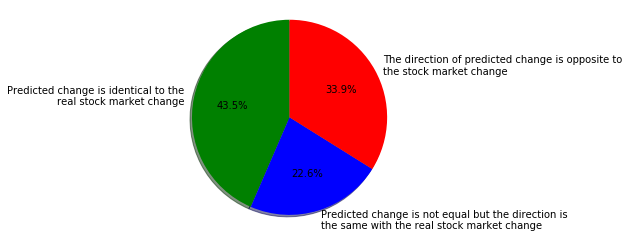

In [8]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
text1=textwrap.fill('Predicted change is identical to the real stock market change', width=40)
text2=textwrap.fill('Predicted change is not equal but the direction is the same with the real stock market change', width=50)
text3=textwrap.fill('The direction of predicted change is opposite to the stock market change', width=50)
labels = text1, text2, text3
colors  = ("green", "blue", "red")
sizes = [len(tweets_df)-len(tweets_dfx),len(tweets_df1)+len(tweets_df2),len(tweets_dfx)-(len(tweets_df1)+len(tweets_df2))]
#print(len(tweets_df),len(tweets_df1), len(tweets_df2))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [9]:
#descriptive statistics


#stats for stock market data in predicted and original classes - not very informative
grouped_data = tweets_df.groupby(['orig changes']) #try adding 'predicted changes'
grouped_data['orig stock'].apply(mode, axis=None).reset_index()
descr = grouped_data['orig stock'].aggregate([np.median, np.std, np.mean, np.min, np.max]).reset_index()
descr

,orig changes,median,std,mean,amin,amax
0,BIGNEG,17749.08980,3363.192650,19335.126438,15914.7402,26743.5000
1,BIGPOS,17740.83010,3597.364175,19976.542655,15660.1797,26405.7598
2,MEDNEG,18502.99020,2921.560010,20100.856458,16014.3799,26562.0508
3,MEDPOS,20896.60940,2926.116295,20688.680231,15766.7402,26656.9805
4,SMANEG,19890.96975,2524.382521,20181.044877,16027.0498,26214.5996
5,SMAPOS,20611.85940,2822.631892,20512.299729,15988.0801,26145.9902


In [10]:
#stats for TF/IDF-scores in predicted and original classes 
grouped_data = tweets_dfbms.groupby(['orig changes']) #try adding 'predicted changes'
grouped_data['tf_idf'].apply(mode, axis=None).reset_index()
descr = grouped_data['tf_idf'].aggregate([np.median, np.std, np.mean, np.min, np.max]).reset_index()
descr

,orig changes,median,std,mean,amin,amax
0,BIGNEG,0.001590,0.004487,0.003113,0.001116,0.036860
1,BIGPOS,0.001125,0.002593,0.002090,0.000801,0.020798
2,MEDNEG,0.000871,0.002353,0.001729,0.000592,0.021138
3,MEDPOS,0.000836,0.002463,0.001669,0.000584,0.020161
4,SMANEG,0.001507,0.003319,0.002824,0.001093,0.021234
5,SMAPOS,0.001825,0.003259,0.003213,0.001389,0.024217


In [11]:
#2 Way Cross table/frequency table for amounts of tweet distribution between original stock market change classes and 
#predicted classes
pd.crosstab(tweets_df['orig changes'],tweets_df['predicted changes'], margins=True)

predicted changes,BIGNEG,BIGPOS,MEDNEG,MEDPOS,SMANEG,SMAPOS,All
orig changes,,,,,,,
BIGNEG,59,29,41,30,25,23,207
BIGPOS,31,87,52,53,43,28,294
MEDNEG,48,51,163,63,35,35,395
MEDPOS,43,46,47,228,32,26,422
SMANEG,22,14,23,22,117,10,208
SMAPOS,14,12,24,22,8,79,159
All,217,239,350,418,260,201,1685


In [12]:
    #2 Way Cross table/frequency percentage table for amounts of tweet distribution between original stock market change classes and 
#predicted classes
pd.crosstab(tweets_df['orig changes'],tweets_df['predicted changes'], margins=True, normalize='index')\
        .round(4)*100

predicted changes,BIGNEG,BIGPOS,MEDNEG,MEDPOS,SMANEG,SMAPOS
orig changes,,,,,,
BIGNEG,28.50,14.01,19.81,14.49,12.08,11.11
BIGPOS,10.54,29.59,17.69,18.03,14.63,9.52
MEDNEG,12.15,12.91,41.27,15.95,8.86,8.86
MEDPOS,10.19,10.90,11.14,54.03,7.58,6.16
SMANEG,10.58,6.73,11.06,10.58,56.25,4.81
SMAPOS,8.81,7.55,15.09,13.84,5.03,49.69
All,12.88,14.18,20.77,24.81,15.43,11.93


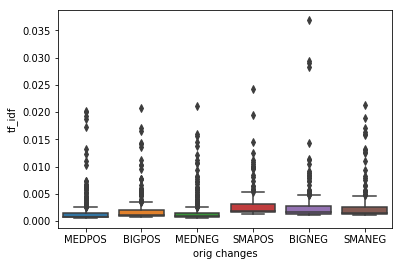

In [13]:
#distribution of TF/IDF scores within original stock market classes
sns.boxplot(x="orig changes", y="tf_idf", data=tweets_dfbms)

C:\Users\Suvi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


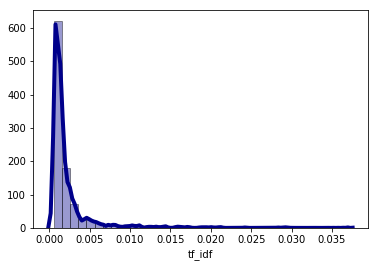

In [14]:
# Density Plot and Histogram of TF/IDF scores -not Gaussian
sns.distplot(tweets_dfbms['tf_idf'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\Suvi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


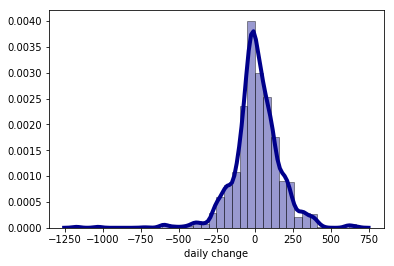

In [15]:
# Density Plot and Histogram of daily change -clearly Gaussian, normally distributed
sns.distplot(tweets_dfbms['daily change'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

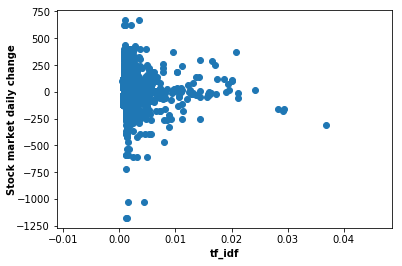

In [16]:
# plotting the data
pyplot.scatter(tweets_dfbms['tf_idf'],tweets_dfbms['daily change'])
pyplot.xlabel('tf_idf', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
pyplot.ylabel('Stock market daily change', fontweight='bold', color = 'black', fontsize='10', verticalalignment='center')
pyplot.show()

In [18]:
#Test of independency for two variables
#Spearman's and Kendall's Tau Correlation tests can be done also for non-normally distributed variables
#Pearson's correlation is reliable only for normally distributed variables
#if the p-value is much lower than 0.05, we reject the null hypothesis 
#and conclude that there is a statistically significant correlation

# calculate the correlation between two variables
def correlation_test(data1, data2, alpha):
    coef1, p_value1 = spearmanr(data1, data2)
    coef2, p_value2 = kendalltau(data1, data2)
    coef3, p_value3 = pearsonr(data1, data2)
    test=[['Spearmans correlation test',coef1,p_value1], ['Kendalltau correlation test',coef2,p_value2], 
          ['Pearsons correlation test',coef3,p_value3]]
    
    print("Test method                ", '\t', "Corr coefficient", '\t', "p-value", '\t', "Results")
    print("-----------------------------------------------------------------------------------------------")
    
    for value in test:
        #print(value[0], 'correlation coefficient: %.3f' % value[1])

        # interpret the significance
        if value[2] > alpha:
            #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % value[2])
            result='Samples are uncorrelated'

        else:
            #print('Samples are correlated (reject H0) p=%.3f' % value[2])
            result='Samples are correlated'
        
        print(value[0] , '\t', "%.2f" % value[1], '         ', '\t', "%.3f" % value[2], '       ', '\t', result)
          

correlation_test(tweets_dfbms['tf_idf'],tweets_dfbms['daily change'], 0.05)  


Test method                 	 Corr coefficient 	 p-value 	 Results
-----------------------------------------------------------------------------------------------
Spearmans correlation test 	 -0.10           	 0.000         	 Samples are correlated
Kendalltau correlation test 	 -0.06           	 0.000         	 Samples are correlated
Pearsons correlation test 	 -0.06           	 0.016         	 Samples are correlated
